In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
from topo_util import noisy_circle, noisy_ellipses
import sklearn as sk
import sklearn.decomposition
import math
import pd
import hypernetx as hnx
import tpot
import topf

## Topological Optimal Transport

#### Generate source and target point clouds

We generate a source point cloud as a disjoint union of 4 circles. The target point cloud is instead given by a flower with 4 ellipses as petals. 

In [494]:
def gen_pts(n_pts = 50, noise_level = 0, seed = 42):
    # Source point cloud
    np.random.seed(seed)
    data1 = noisy_circle(n_pts, 0.5*noise_level, 0, 0, 3 )
    data2 = noisy_circle(n_pts, 0.5*noise_level, 10, 0, 3 )
    data3 = noisy_circle(n_pts, 0.5*noise_level, 20, 0, 3 )
    data4 = noisy_circle(n_pts, 0.5*noise_level, 30, 0, 3 )
    A = np.concatenate([data1, data2, data3, data4])
    # Target point cloud
    np.random.seed(seed)
    data1 = noisy_ellipses(n_pts, 2.5*noise_level, 3, 8, 0, 0 )
    data2 = noisy_ellipses(n_pts, 2.5*noise_level, 3, 8, 0, -16)
    data3 = noisy_ellipses(n_pts, 2.5*noise_level, 8, 3, -9, -8)
    data4 = noisy_ellipses(n_pts, 2.5*noise_level, 8, 3, 9, -8)
    B = np.concatenate([data1, data2, data3, data4])
    return A, B

n_pts = 50
# noise_level = 1e-9 
noise_level = 1.0
A, B = gen_pts(n_pts = n_pts, noise_level = noise_level)

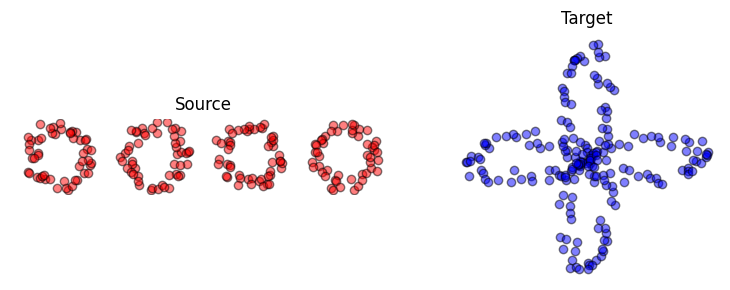

In [495]:
plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
plt.scatter(A[:,0],A[:,1], color = 'red', edgecolors = 'k', alpha = 0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis("off")
plt.title("Source")
plt.subplot(1, 2, 2)
plt.scatter(B[:,0],B[:,1], color = 'blue', edgecolors = 'k', alpha = 0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis("off")
plt.title("Target")
plt.tight_layout()
plt.savefig(f'../outputs/loops_scatter_noise_{noise_level}.svg')
plt.show()

In [496]:
# Compute pairwise distance matrices for source A and target B
def get_affinities(X, gaussian = True):
    C = sp.spatial.distance.cdist(X, X, metric = "sqeuclidean")
    C /= np.mean(C)
    if gaussian:
        C = np.exp(-C)
    return C
C_v0, C_v1 = get_affinities(A), get_affinities(B)
p, q = ot.unif(len(A)), ot.unif(len(B))

In [497]:
# baseline: Compute GW matching between source A and target B
gw0, log0 = ot.gromov.gromov_wasserstein(
    C_v0, C_v1, p, q, 'square_loss', verbose=True, log=True)
P = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
Id = [t[0] for t in A]
p = np.matmul(P, Id)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.039388e-01|0.000000e+00|0.000000e+00
    1|1.331877e-01|5.312136e-01|7.075110e-02
    2|1.023432e-01|3.013833e-01|3.084452e-02
    3|9.468709e-02|8.085651e-02|7.656068e-03
    4|9.389194e-02|8.468831e-03|7.951550e-04
    5|9.329406e-02|6.408534e-03|5.978782e-04
    6|9.267871e-02|6.639607e-03|6.153502e-04
    7|9.207579e-02|6.548043e-03|6.029163e-04
    8|9.066589e-02|1.555055e-02|1.409905e-03
    9|8.265332e-02|9.694194e-02|8.012573e-03
   10|7.084952e-02|1.666037e-01|1.180379e-02
   11|6.671404e-02|6.198826e-02|4.135487e-03
   12|5.889176e-02|1.328247e-01|7.822278e-03
   13|5.624014e-02|4.714810e-02|2.651616e-03
   14|5.595156e-02|5.157695e-03|2.885811e-04
   15|5.591780e-02|6.037117e-04|3.375823e-05
   16|5.591780e-02|3.910455e-09|2.186641e-10


In [498]:
# Construct color scale for plotting
one = topo_util.get_eigvec(A[:n_pts])
one = one - min(one)
one = (one/max(one))/4
two = topo_util.get_eigvec(A[n_pts:2*n_pts])
two = two - min(two)
two = 0.25 + (two/max(two))/4
three = topo_util.get_eigvec(A[2*n_pts:3*n_pts])
three = three - min(three)
three = 0.5 + (three/max(three))/4
four = topo_util.get_eigvec(A[3*n_pts:4*n_pts])
four = four - min(four)
four = 0.75 + (four/max(four))/4
color_figures = np.concatenate([one,two, three,four])

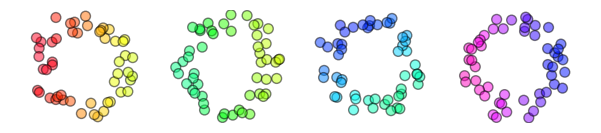

In [499]:
fig = plt.figure(figsize = (7.5, 7.5))
ax = fig.add_subplot()
scat = ax.scatter(A[:,0],A[:,1],c = color_figures, s=50,edgecolors='k', vmax=1, vmin=0, cmap = "gist_rainbow", alpha = 0.5)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig(f'../outputs/loops_source_noise_{noise_level}.svg')
plt.show()

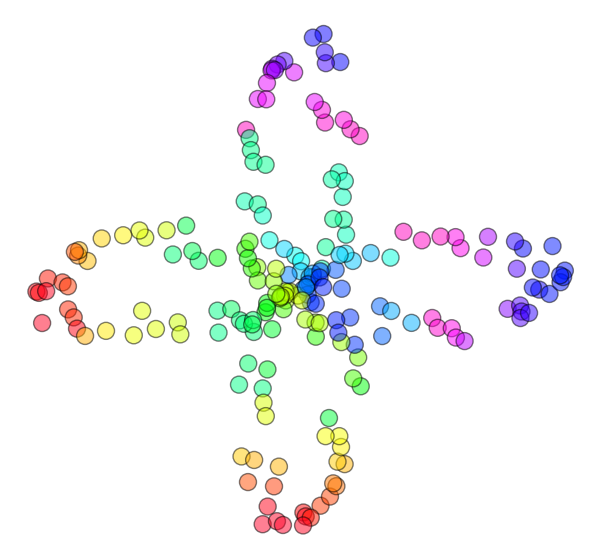

In [500]:
fig = plt.figure(figsize = (7.5, 7.5))
ax = fig.add_subplot()
P_gromov = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
p_gromov = np.matmul(P_gromov, color_figures)
plt.scatter(B[:,0], B[:,1], c = p_gromov, s=150, edgecolors='k', vmax=1, vmin=0, cmap = "gist_rainbow", alpha = 0.5)
plt.gca().set_aspect('equal', adjustable='box')
ax.set_axis_off()
plt.savefig(f'../outputs/loops_target_GW_{noise_level}.svg')
plt.show()

### Compute PH and PH-hypergraph

In [524]:
# Switch to using TOPF
use_topf = True
if use_topf:
    topf_all = [topf.topf(x, return_dict = True, complex_type = 'rips', fixed_num_features = [0, 10]) for x in tqdm([A, B])]
    y0 = topf_all[0][0]
    y1 = topf_all[1][0]
    df1, df2 = [pandas.DataFrame({"b" : x[1]['birth_times'], "d" : x[1]['death_times'], "pers" : np.array(x[1]['death_times']) - np.array(x[1]['birth_times'])}) for x in topf_all]
    p_spt, q_spt = df1.iloc[:, :2].values, df2.iloc[:, :2].values
else:
    def PH(X):
        df = pandas.DataFrame()
        for ii in range(X.shape[1]):
            df['x_{}'.format(ii)] =  X[:,ii]
        df.to_csv("pointcloud.tsv", sep = '\t', index = False)
        !julia ../src/PH.jl 
        with open('PH.json','r') as f:
            dic = json.load(f)
        return dic   
    # Compute 1-dimensional PH and representative cycles of each dataset. 
    H_all = [PH(x) for x in tqdm([A,B])]
    # Transforms barcodes in dataframes
    df1 = topo_util.make_dataframe(H_all[0]["barcode"])
    df2 = topo_util.make_dataframe(H_all[1]["barcode"])
    # Compute the augmented Wasserstein cost matrix between target and source barcode
    p_spt = df1.iloc[:, 0:2].to_numpy()
    q_spt = df2.iloc[:, 0:2].to_numpy()
    # Construct PH-hypeprgraphs from H_all
    G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]
    y0, w0, v0 = topo_util.process_hg(G_all[0], A.shape[0])
    y1, w1, v1 = topo_util.process_hg(G_all[1], B.shape[0])
    # similarity with kernel
    h = 0.25
    K0 = topo_util.get_kernel(A, h)
    L0 = topo_util.symmetric_laplacian(K0)
    K1 = topo_util.get_kernel(B, h)
    L1 = topo_util.symmetric_laplacian(K1)
    y0_imputed = topo_util.impute_laplacian(y0, L0)
    y1_imputed = topo_util.impute_laplacian(y1, L1) 
    y0 = y0_imputed; y1 = y1_imputed;

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.96s/it]


In [525]:
# Get weights and cost on the PD space 
p, q = pd.augmented_weights(p_spt, q_spt)
C = pd.augmented_cost(p_spt, q_spt)
C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= C_pd.mean()

In [526]:
C_v0, C_v1 = get_affinities(A), get_affinities(B)

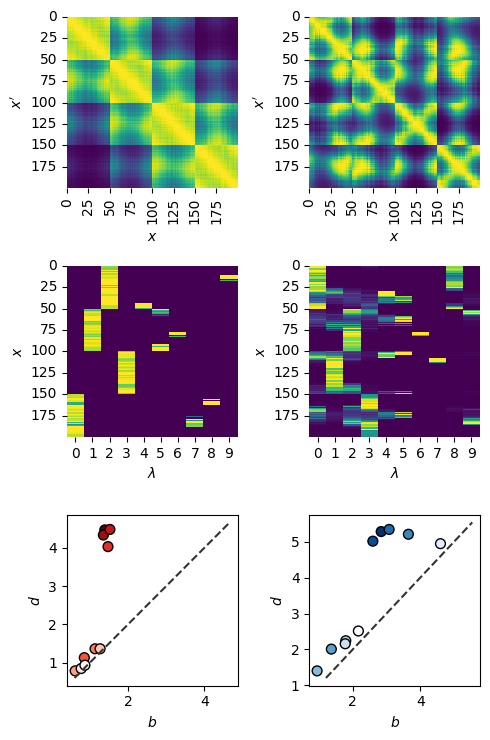

In [527]:
importlib.reload(pd)
plt.figure(figsize = (5, 7.5))
plt.subplot(3, 2, 1)
sb.heatmap(C_v0, cmap = 'viridis', cbar = False, rasterized = True)
plt.yticks(ticks=np.arange(0, C_v0.shape[0], 25), labels=np.arange(0, C_v0.shape[0], 25))
plt.xticks(ticks=np.arange(0, C_v0.shape[0], 25), labels=np.arange(0, C_v0.shape[0], 25))
plt.xlabel("$x$"); plt.ylabel("$x'$")
plt.subplot(3, 2, 2)
sb.heatmap(C_v1, cmap= 'viridis', cbar = False, rasterized = True);
plt.yticks(ticks=np.arange(0, C_v0.shape[0], 25), labels=np.arange(0, C_v0.shape[0], 25))
plt.xticks(ticks=np.arange(0, C_v0.shape[0], 25), labels=np.arange(0, C_v0.shape[0], 25))
plt.xlabel("$x$"); plt.ylabel("$x'$")
plt.subplot(3, 2, 3)
sb.heatmap(y0, cmap = 'viridis', cbar = False, rasterized = True); plt.yticks(ticks=np.arange(0, C_v0.shape[0], 25), labels=np.arange(0, C_v0.shape[0], 25))
plt.ylabel("$x$"); plt.xlabel("$\\lambda$")
plt.subplot(3, 2, 4)
sb.heatmap(y1, cmap= 'viridis', cbar = False, rasterized = True); plt.yticks(ticks=np.arange(0, C_v0.shape[0], 25), labels=np.arange(0, C_v0.shape[0], 25))
plt.ylabel("$x$"); plt.xlabel("$\\lambda$")
plt.subplot(3, 2, 5)
pd.plot_pd(p_spt, color = np.arange(p_spt.shape[0]), cmap = "Reds_r")
plt.xlabel("$b$"); plt.ylabel("$d$")
plt.subplot(3, 2, 6)
pd.plot_pd(q_spt, color = np.arange(q_spt.shape[0]), cmap = "Blues_r")
plt.xlabel("$b$"); plt.ylabel("$d$")
plt.tight_layout()
plt.savefig(f"../outputs/loops_heatmaps_noise_{noise_level}_topf_{use_topf}.svg")

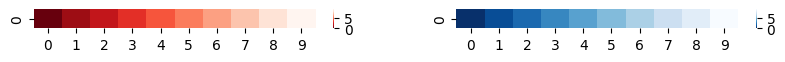

In [528]:
plt.figure(figsize = (10, 0.25))
plt.subplot(1, 2, 1)
sb.heatmap(np.arange(q_spt.shape[0])[None, :], cmap = "Reds_r")
plt.subplot(1, 2, 2)
sb.heatmap(np.arange(q_spt.shape[0])[None, :], cmap = "Blues_r")
plt.savefig("../outputs/colors.svg")

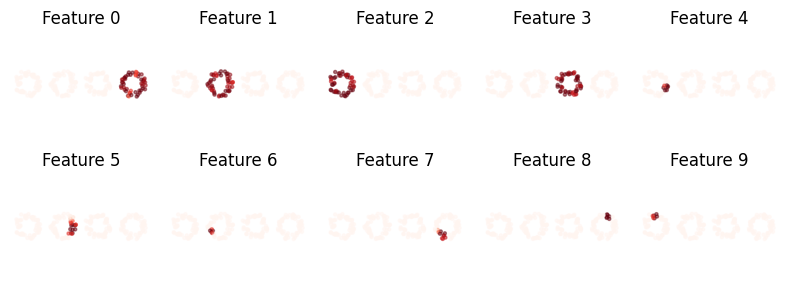

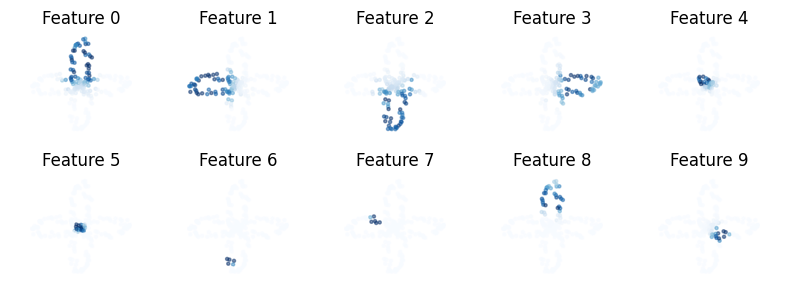

In [529]:
plt.figure(figsize = (8, 3))
for i in range(min(10, y0.shape[1])):
    plt.subplot(2, 5, i+1)
    plt.scatter(A[:, 0], A[:, 1], c = y0[:, i], alpha = 0.5, s = 5, cmap = "Reds")
    plt.title(f"Feature {i}")
    plt.axis('off')
    plt.axis("equal")
plt.tight_layout()
plt.savefig(f"../outputs/loops_A_features_noise_{noise_level}_topf_{use_topf}.svg")

plt.figure(figsize = (8, 3))
for i in range(min(10, y1.shape[1])):
    plt.subplot(2, 5, i+1)
    plt.scatter(B[:, 0], B[:, 1], c = y1[:, i], alpha = 0.5, s = 5, cmap = "Blues")
    plt.title(f"Feature {i}")
    plt.axis('off')
    plt.axis("equal")
plt.tight_layout()
plt.savefig(f"../outputs/loops_B_features_noise_{noise_level}_topf_{use_topf}.svg")

In [530]:
alpha = 0.5
beta = 1.0

w0 = ot.unif(y0.shape[0])
w1 = ot.unif(y1.shape[0])
v0 = p
v1 = q
pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1, 
                           C_v0, C_v1, C_pd, 
                           beta = beta, alpha = alpha, print_iter = 10, iter = 100,
                           solver = "sinkhorn", 
                           eps_s = 0.003, eps_f = 0.01, numItermax = 2500)

P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
Q[np.isnan(Q)] = 0

Iteration 0,	 obj = 0.11821541581866919,	 obj_terms = {'coot': 0.04143579225937977, 'ot': 0.039249268647961535, 'gw': 0.03753035491132789}
Iteration 10,	 obj = 0.0986486409200196,	 obj_terms = {'coot': 0.03150540378156699, 'ot': 0.03947657567386187, 'gw': 0.027666661464590736}
Iteration 20,	 obj = 0.09865856065771475,	 obj_terms = {'coot': 0.03141833532487507, 'ot': 0.039585709046566483, 'gw': 0.027654516286273207}
Iteration 30,	 obj = 0.09865875927246097,	 obj_terms = {'coot': 0.03141679302298653, 'ot': 0.03958777315640809, 'gw': 0.027654193093066354}
Iteration 40,	 obj = 0.09865875645261535,	 obj_terms = {'coot': 0.03141677104498042, 'ot': 0.039587798819913936, 'gw': 0.02765418658772099}
Iteration 50,	 obj = 0.09865875522524703,	 obj_terms = {'coot': 0.03141677149676626, 'ot': 0.039587797465929025, 'gw': 0.02765418626255174}
Iteration 60,	 obj = 0.09865875492639939,	 obj_terms = {'coot': 0.03141677182230308, 'ot': 0.039587796879813716, 'gw': 0.02765418622428259}
Iteration 70,	 obj = 

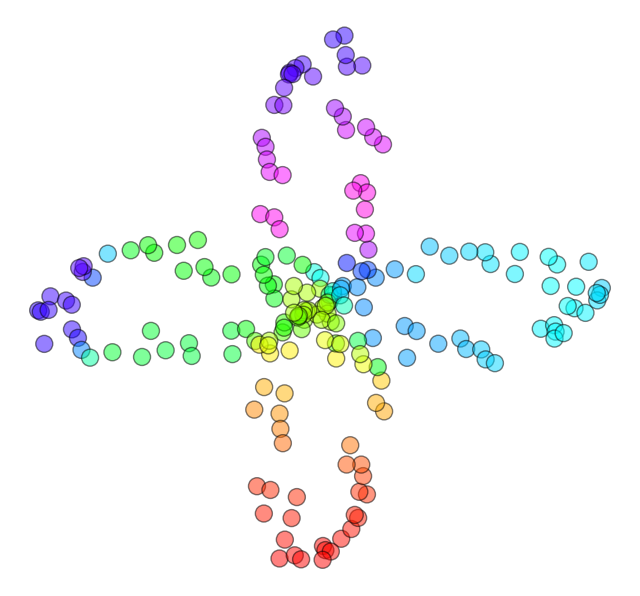

In [531]:
color_target  = np.matmul(P.T, color_figures)

fig = plt.figure()
ax = fig.add_subplot()
P_gromov = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
p_gromov = np.matmul(P_gromov, color_figures)

plt.scatter(B[:,0], B[:,1], c = color_target, s=150, edgecolors='k', vmax=1, vmin=0, cmap = "gist_rainbow", alpha = 0.5)
plt.gca().set_aspect('equal', adjustable='box')
ax.set_axis_off()

plt.savefig(f'../outputs/loops_target_tpot_noise_{noise_level}_topf_{use_topf}_alpha{alpha}_beta{beta}.svg')

plt.show()

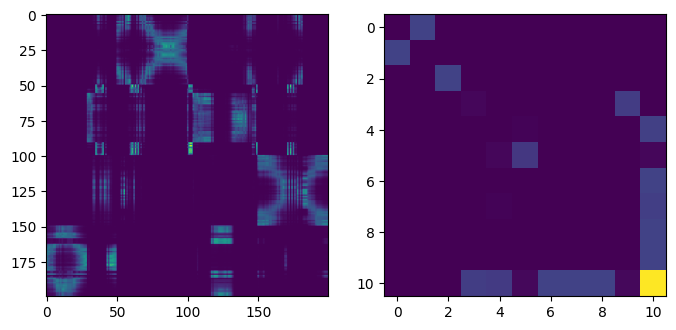

In [532]:
plt.subplot(1,2,1)
plt.imshow(pi_s)
plt.subplot(1,2,2)
plt.imshow(pi_f)

In [510]:
# Find geodesic
matching = np.array(np.where(ot.emd(w0, w1, pi_s.max()-pi_s) > 0)).T # round coupling
def geodesic_distances(a,b,t,indices):
    #Compute pairwise distance between points in geodesic
    N = len(indices)
    M = np.zeros((N, N))
    for ii in range(N):

        Pi = a[indices[ii][0]]
        Qi = b[indices[ii][1]]
        Pi = np.array(Pi)
        Qi = np.array(Qi)
        for jj in range(ii+1, N):
            Pj = a[indices[jj][0]]
            Qj = b[indices[jj][1]]
            
            Pj = np.array(Pj)
            Qj = np.array(Qj)
            da = np.linalg.norm(Pi - Pj)
            db = np.linalg.norm(Qi - Qj)
            M[ii][jj] = t* da + (1-t)*db
    return M + M.T 

def convex_point(a,b,t,indices):
    N = len(indices)
    v = []
    for ii in range(N):

        Pi = a[indices[ii][0]]
        Qi = b[indices[ii][1]]
        Pi = np.array(Pi)
        Qi = np.array(Qi)
        v.append( Pi*t + Qi*(1-t))
    return v

In [318]:
num_frames = 100
x1 = np.linspace(0, 1, num_frames, endpoint=True)
matrices = [geodesic_distances(A,B,t, matching) for t in x1]
convex_points = np.array([convex_point(A,B,t, matching) for t in x1])

In [319]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances

model = MDS(n_components=2, dissimilarity='precomputed', random_state=2002)

In [320]:
from scipy.spatial.transform import Rotation as R
def align(AA,BB):
    AA = [[aa[0], aa[1], 0] for aa in AA]
    BB = [[aa[0], aa[1], 0] for aa in BB]
    rot, rssd, sens = R.align_vectors(BB, AA, return_sensitivity=True)
    return rot.apply(AA)[:,:2]
def reflect(a):
    return np.array([ [aa[0], -aa[1]] for aa in a ])

In [321]:
import warnings
warnings.filterwarnings("ignore")
models = []
out = model.fit(matrices[0]).embedding_
pos = align(out, convex_points[0])
models_alligned = [pos]
for ii in range(1, num_frames):
    true = convex_points[ii]
    out = model.fit(matrices[ii]).embedding_
    pos = align(out, true)
    rpos = reflect(pos)
    if np.linalg.norm(models_alligned[-1] - pos) >  np.linalg.norm(models_alligned[-1] - rpos):
        pos = rpos
    models.append(out)
    models_alligned.append(pos)

In [322]:
frames = []
for i in range(0, num_frames):
    df = pandas.DataFrame()
    df['x'] = list(np.array(models_alligned[i]).T[0])
    df['y'] = list(np.array(models_alligned[i]).T[1])
    df['frame'] = i
    df['color'] = np.concatenate([[0 for jj in range(50)],[0.33 for jj in range(50)],[0.66 for jj in range(50)],[1 for jj in range(50)]])
    frames.append(df)

DF = pandas.concat(frames)
DF['size'] = 30

In [415]:
100-np.arange(1, num_frames+1, step = 10), 99-np.arange( num_frames, step = 10)

(array([99, 89, 79, 69, 59, 49, 39, 29, 19,  9]),
 array([99, 89, 79, 69, 59, 49, 39, 29, 19,  9]))

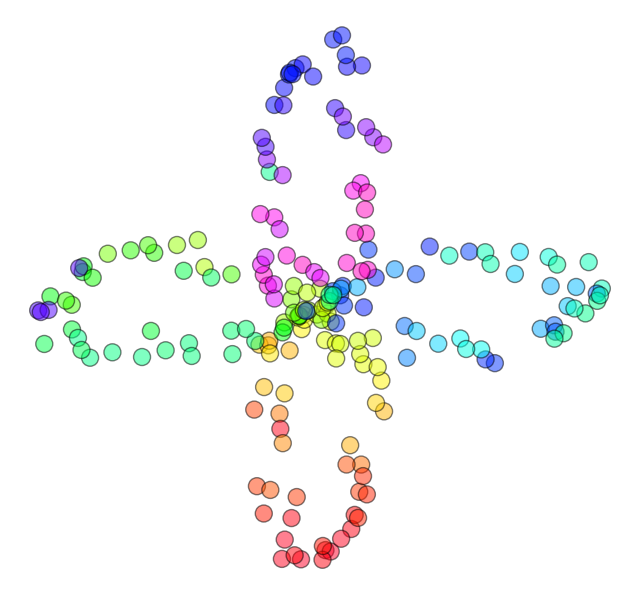

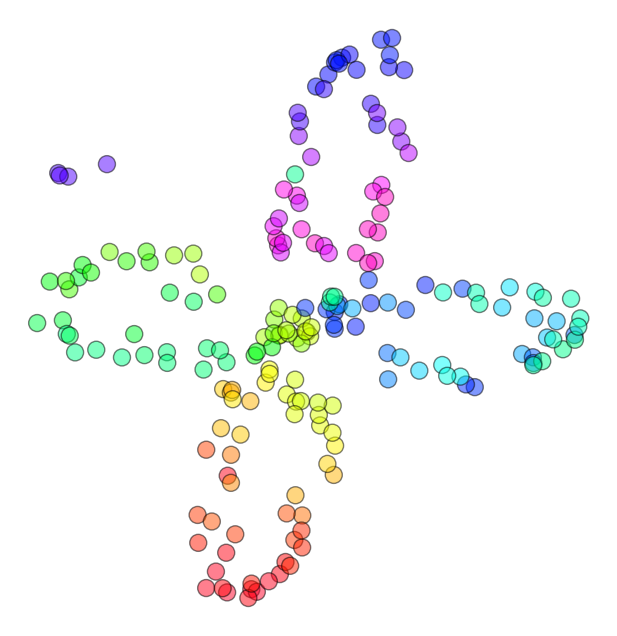

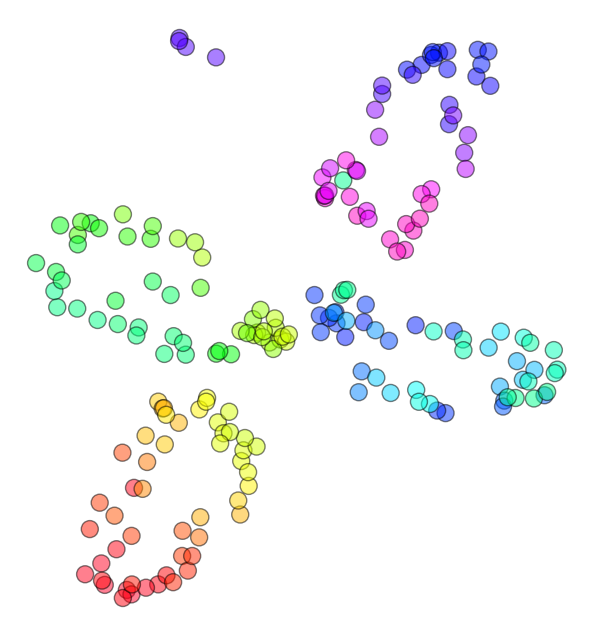

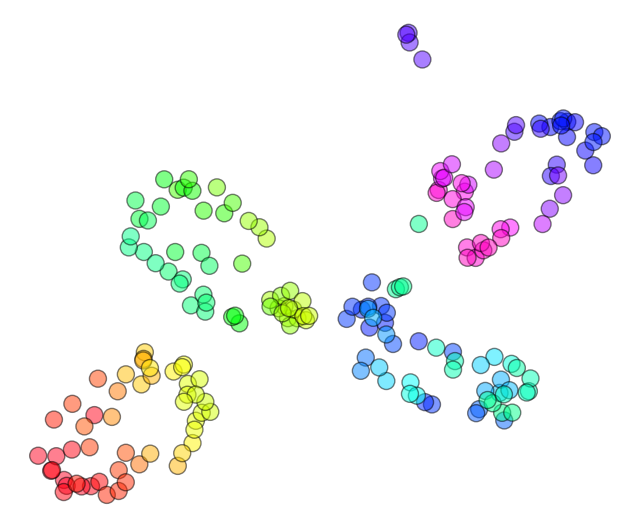

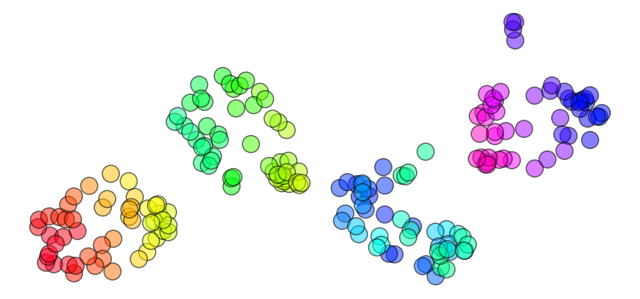

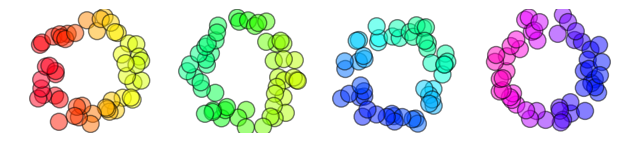

In [417]:
import matplotlib.animation as animation
N = 200 # number of points 
# for j in np.arange(num_frames+1, step = 10):
#     i = 99 -j
for i in [0, 20, 40, 60, 80, 99]: 
    fig = plt.figure()
    j = 99 -i
    ax = fig.add_subplot()
    scat = ax.scatter(DF['x'][i*N:N*(1+i)], DF['y'][i*N:N*(1+i)], 
                      marker='o', 
                      s=150,
                      # c = DF['color'][i*N:N*(1+i)],
                      c = color_figures,
                      alpha= 0.5, edgecolors='black', cmap = "gist_rainbow")
    ax.set_axis_off()
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.tight_layout()
    plt.savefig('../outputs/geodesic_{}_{}_{}.svg'.format(alpha,beta,j))
    plt.show()


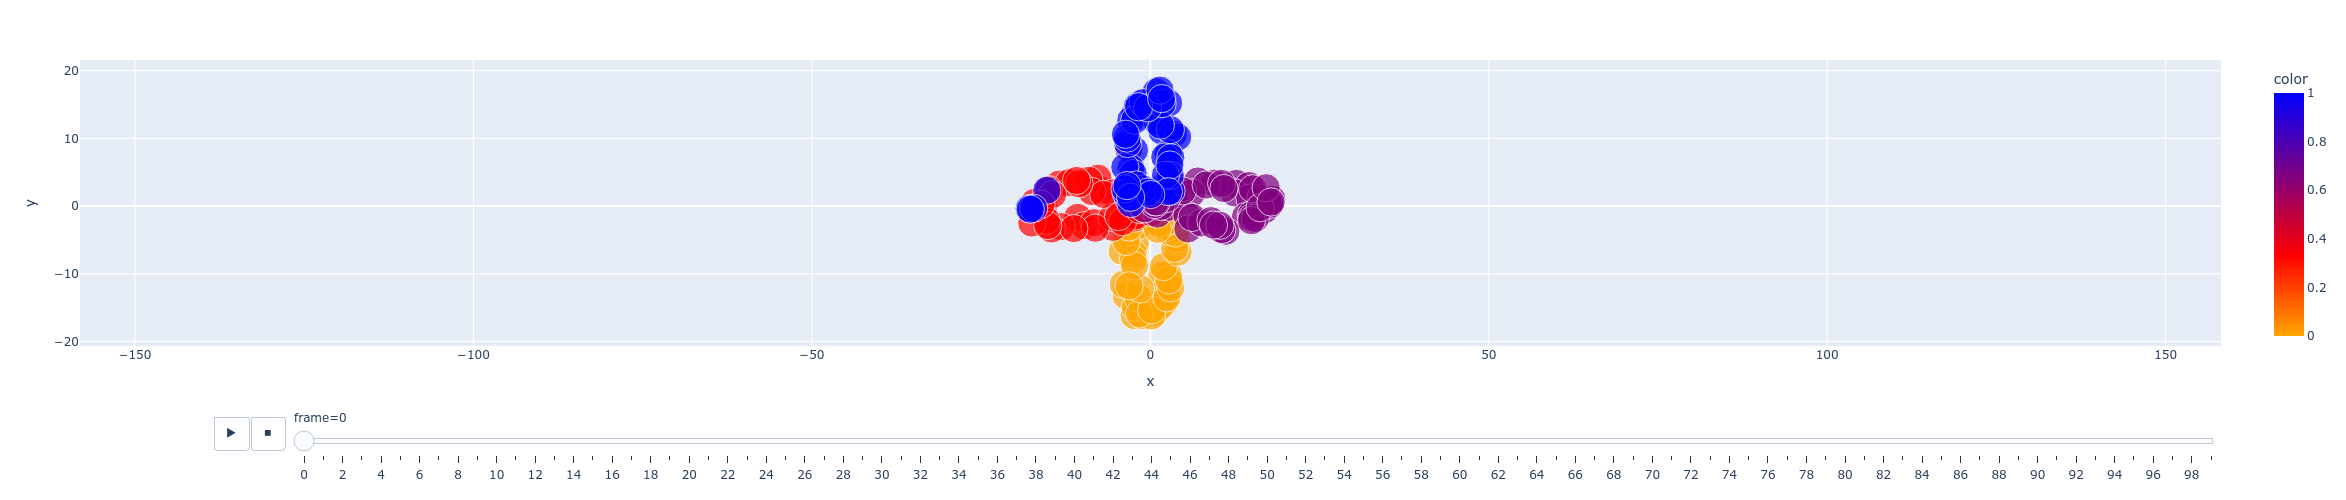

In [418]:
new_scale=[
                [0.0,'orange'],
                [0.33, 'red'],
                [0.66, 'purple'],
                [1.0, 'blue']]
df = px.data.gapminder()
fig = px.scatter(DF, x="x", y="y", animation_frame="frame",size='size', color= 'color',
                 color_continuous_scale= new_scale,
            )
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
    #plt.savefig('outputs/loops_geo_{}.png'.format(j))
    #plt.savefig('outputs/loops_geo_{}.pdf'.format(j))
fig.update_layout(
    width = 600,
    height = 500,
)
fig.show()

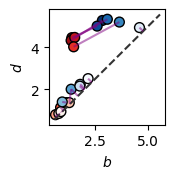

In [419]:
sizes_p = 10 + np.zeros((len(p_spt)))
sizes_q = 10 + np.zeros((len(q_spt)))
sizes_p[:4] = 100
sizes_q[:4] = 100

importlib.reload(pd)
plt.figure(figsize = (1.5, 1.5))

pd.plot_pd(p_spt, color = np.arange(p_spt.shape[0]), cmap = "Reds_r", plot_diagonal = False)
pd.plot_pd(q_spt, color = np.arange(q_spt.shape[0]), cmap = "Blues_r")
pd.plot_pd_connections(p, q, p_spt, q_spt, pi_f)
plt.xlabel("$b$"); plt.ylabel("$d$")
plt.savefig('../outputs/pds_ex1.svg', dpi=300)